# Étapes
Souligné = fait
### Gradient
<ins>Sobel</ins>, Convolution avec masque quelconque, gradient couleur, morphologique ?
### Cellules
Grid : <ins>rectangulaire</ins>, <ins>hexagonnal</ins>, grid en fonction du nombre de pixel voulu   
Assignation des cellules : <ins>Carte de distance</ins>, <ins>seuillage</ins>, composantes connexes
### Markers par cellules
<ins>Minima par cellules</ins>, composantes connexes -> la plus grande, cas particuliers
### Carte de distance par cellule + gradient
Distances aux markers, normalisation adaptée
### Watershed
?
### Évaluation des résultats, comparaison avec d'autres techniques

In [40]:
# FONCTIONS

# Gradient
def sobel_x(img):
    n, m=img.shape
    gradx=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            gradx[i,j] = img[i-1,j+1] + 2*img[i,j+1] + img[i+1,j+1] - img[i-1,j-1] - 2*img[i,j-1] - img[i+1,j-1]
            
    return gradx
              

def sobel_y(img):
    n, m=img.shape
    grady=np.zeros((n, m))

    for i in range(1,n-1):
        for j in range(1,m-1):
            grady[i,j] = img[i-1,j-1] + 2*img[i-1,j] + img[i-1,j+1] - img[i+1,j-1] - 2*img[i+1,j] - img[i+1,j+1]
        
    return grady

def sobel(img):
    gradx, grady = sobel_x(img), sobel_y(img)
    grad = np.sqrt(gradx*gradx+grady*grady)
    grad[0]=grad[1]
    grad[n-1]=grad[n-2]
    grad[:,0]=grad[:,1]
    grad[:,m-1]=grad[:,m-2]
    return grad
# Carte de distance
def carte_distance(img_bin, 
                   masque_avant=[(-2,-1,11),(-2,1,11),(-1,-2,11),(-1,-1,7),(-1,0,5),(-1,1,7),(-1,2,11),(0,-1,5),(0,0,0)],
                   masque_arriere=[(0,0,0),(0,1,5),(1,-2,11),(1,-1,7),(1,0,5),(1,1,7),(1,2,11),(2,-1,11),(2,1,11)]
                  ):
    
    carte = np.copy(img_bin)
    for i in range(n):
        for j in range(m):
            if img_bin[i, j]==0:
                carte[i, j]=np.inf
        
    for l in range(n):
        for c in range(m):
            C=[]
            for a in masque_avant:
                i, j, v = a
                if l+i<n and c+j<m and l+i>=0 and c+j>=0:
                    C.append(carte[l+i, c+j]+v)      
            carte[l, c] = min(C)

    for l in range(n-1,-1,-1):
        for c in range(m-1,-1,-1):
            C=[]
            for a in masque_arriere:
                i, j, v = a
                if l+i<n and c+j<m and l+i>=0 and c+j>=0:
                    C.append(carte[l+i, c+j]+v)
            carte[l, c] = min(C)
    
    return carte

# Cellules
def cell_centers(img, sp_in_line, grid="square"):
    n, m = img.shape
    centers = np.zeros_like(img)
    centers_coordinates = []
    
    if grid=="square":
        sigma = int(np.round(m/sp_in_line))
        print(sigma)
        for i in range(sigma//2,n,sigma):
            for j in range(sigma//2,m,sigma):
                centers[i,j]=255
                centers_coordinates.append((i,j))
                    
    if grid=="hexa":
        sigma=np.round(m/(3/2*sp_in_line))
        step_l, step_c = int(np.round((np.sqrt(3)/2)*sigma)), int(np.round((3/2)*sigma))
        d_c=m-(sp_in_line-1)*step_c
        offset_c=int(np.round(d_c/2))
        
        for i in range(0,n,2*step_l):
            for j in range(offset_c,m,2*step_c):
                centers[i,j]=255
                centers_coordinates.append((i,j))
                
        for i in range(step_l,n,2*step_l):
            for j in range(offset_c+step_c,m,2*step_c):
                centers[i,j]=255
                centers_coordinates.append((i,j))

    return centers, centers_coordinates

def seuillage(carte, p):
    m = np.max(carte[:50, :50])
    seuil = p*m
    carte_seuil = np.zeros_like(carte)
    n, m = carte.shape
    for i in range(n):
        for j in range(m):
            if carte[i, j] < seuil:
                carte_seuil[i, j]=1
            else:
                carte_seuil[i, j]=0
    return carte_seuil

# Etiquetage en composantes connexes
def searchTagsInPast(Map, i, j, type='8'):
    # type = '8' or '4' (4 connected or 8 connected)
    tags = []
    
    if i-1>=0 and Map[j][i-1] > 0:
        if Map[j][i-1] not in tags:
            tags.append(Map[j][i-1])
            
    if j-1>=0 and Map[j-1][i] > 0:
        if Map[j-1][i] not in tags:
            tags.append(Map[j-1][i])
        
    if type=='8':
        if i-1>=0 and j-1>=0 and Map[j-1][i-1] > 0:
            if Map[j-1][i-1] not in tags:
                tags.append(Map[j-1][i-1])
        if i+1<Map.shape[1] and j-1>=0 and Map[j-1][i+1] > 0:
            if Map[j-1][i+1] not in tags:
                tags.append(Map[j-1][i+1])
    return tags

def tagging(im, type='8'):
    # tags are integers starting at 1
    connected_components=[]
    newtag = 0
    tagmap = np.zeros((im.shape[0], im.shape[1]), dtype=np.int8)
    
    tags_list=[[]]

    # Descent
    for j in range(im.shape[0]):
        for i in range(im.shape[1]):
            if im[j][i] > 0 :
                # Look in the pas (pixels up and left)
                pasttags = searchTagsInPast(tagmap, i, j, type)
                if len(pasttags) == 0:
                    newtag += 1
                    tagmap[j][i] = newtag
                    
                    connected_components.append([(j,i)])
                    tags_list.append([newtag])
                    
                elif len(pasttags) == 1:
                    tag=pasttags[0]
                    tagmap[j][i] = pasttags[0]
                    
                    connected_components[tag-1].append((j,i))

                elif len(pasttags) > 1:
                    tag=min(pasttags)
                    tagmap[j][i] = tag
                    
                    
                    connected_components[tag-1].append((j,i))
                    
                    k = pasttags.index(min(pasttags))
                    pasttags.pop(k)
                    
                    for t in pasttags:
                        connected_components[tag-1]+=connected_components[t-1]
                        connected_components[t-1]=[]
                        tags_list[t]=[]
                    
                    tags_list[tag] += pasttags
                    
                    connected_components = rebuild_cc(connected_components)
                    tagmap = rebuild_tagmap(connected_components, im)
                    newtag=np.max(tagmap)
                    
    return tagmap, connected_components


def update_tags(tags_list, connected_components):
    for k in range(len(tags_list)):
        if len(tags_list[k])>1:
            reftag=k
            for i in range(1,tags_list[k]):
                connected_components[k-1]+=connected_components[tags_list[k][i]-1]
                tags_list = update_tags_list(tags_list, k, i)
                
                
def update_tags_list(tags_list, reftag, tag_to_replace):
    for k in range(len(tags_list)):
        for i in range(len(tags_list[k])):
            if tags_list[k][i] == tag_to_replace:
                tags_list[k][i]=reftag
                
                
def rebuild_cc(connected_components):
    new_connected_components = []
    for cc in connected_components:
        if cc!=[]:
            new_connected_components.append(cc)
    return new_connected_components

def rebuild_tagmap(connected_components, im):
    tagmap = np.zeros((im.shape[0], im.shape[1]), dtype=np.int8)
    for k in range(len(connected_components)):
        for point in connected_components[k]:
            j,i=point
            tagmap[j,i]=k+1
            
    return tagmap

# Markers
def get_markers(cellules, grad):
    markers=[]
    for cell in cellules:
        min_grad = np.inf
        markers_in_cell=[]
        for k in range(len(cell)):
            i, j = cell[k]
            if grad[i, j]<=min_grad:
                min_grad=grad[i, j]
                markers_in_cell.append((i, j))
        markers.append(markers_in_cell)
        
    return markers

def img_with_markers(markers_in_cell, img_shape):
    n, m = img_shape
    img=np.zeros((n, m), dtype=np.int8)
    for k in range(len(markers_in_cell)):
        i, j = markers_in_cell[k]
        img[i, j]=1
    return img

def cc_of_max_len(ccs):
    m_l=len(ccs[0])
    index=0
    for k in range(1, len(ccs)):
        if len(ccs[k])>m_l:
            m_l=len(ccs[k])
            index=k

    return index

def get_connected_markers(markers, img_shape):
    connected_markers=[]
    p=0
    for markers_in_cell in markers:
        img_bin=img_with_markers(markers_in_cell, img_shape)
        tagmap, connected_components = tagging(img_bin)
        connected_marker = connected_components[cc_of_max_len(connected_components)]
        connected_markers.append(connected_marker)
        p+=1
        
    return connected_markers

def img_from_markers(markers, img_shape):
    n, m=img_shape
    img_markers = np.zeros((n, m))
    for cell_markers in markers:
        for k in range(len(cell_markers)):
            i, j  = cell_markers[k]
            img_markers[i, j]=1
    return img_markers

In [1]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

(321, 481)

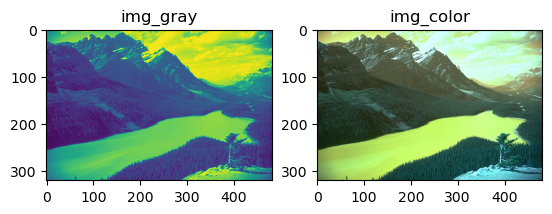

In [26]:
img_gray = cv2.imread('image2.jpg', cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread('image2.jpg')
n, m = img_gray.shape


plt.subplot(1, 2, 1)
plt.imshow(img_gray)        
plt.title("img_gray")

plt.subplot(1, 2, 2)
plt.imshow(img_color)        
plt.title("img_color")
n, m

In [57]:
# Paramètres
sp_in_line = 14
seuil = 0.85

# Gradient
grad=sobel(img_gray)
grad = grad*(255/np.max(grad))
filt_grad = ndi.gaussian_filter(grad, 3)


img_centers=np.zeros((n, m))
centers, centers_coordinates = cell_centers(img_gray, sp_in_line, grid='hexa')
img_centers=img_centers+centers
carte_dist_cells=carte_distance(img_centers)

carte_cells_seuil = seuillage(carte_dist_cells, seuil)

_, cells = tagging(carte_cells_seuil)
markers = get_markers(cells, filt_grad)

img_markers = img_from_markers(markers, (n, m))
        
connected_markers = get_connected_markers(markers, (n, m))
img_connected_markers = img_from_markers(connected_markers, (n, m))
        


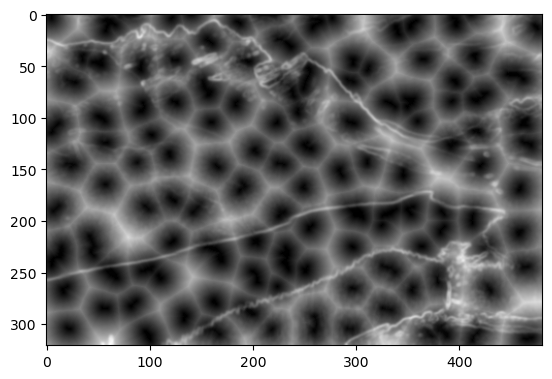

In [123]:
carte_dist_markers=carte_distance(img_connected_markers)

res = carte_dist_markers*2+ndi.gaussian_filter(grad, 1)

plt.imshow(res, cmap='gray')

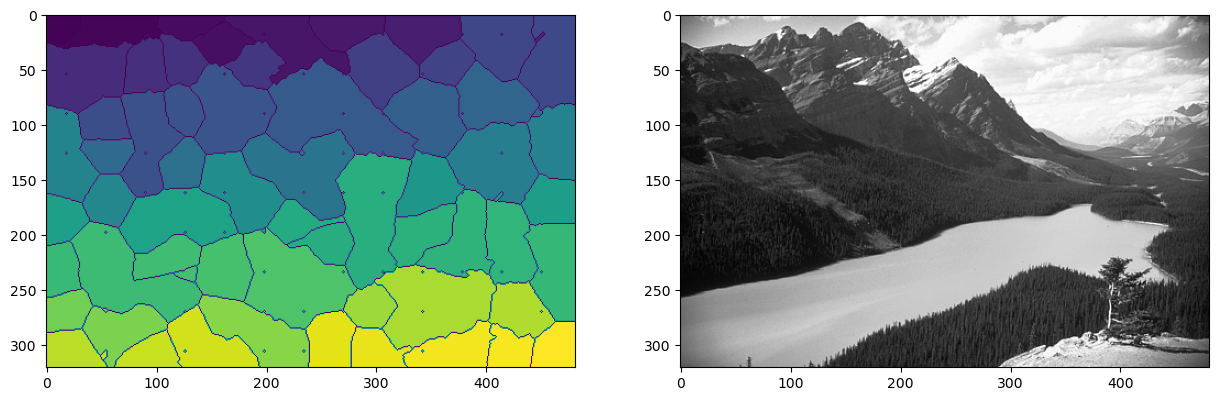

In [124]:
image = np.array(res, dtype=np.int32)

labels = watershed(image, 119, watershed_line=True)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(labels*5)
plt.subplot(1,2,2)
plt.imshow(img_gray, cmap='gray')

In [109]:
labels

array([[  1,   1,   1, ...,  26,  26,  26],
       [  1,   1,   1, ...,  26,  26,  26],
       [  1,   1,   1, ...,  26,  26,  26],
       ...,
       [105, 105, 105, ..., 116, 116, 116],
       [105, 105, 105, ..., 116, 116, 116],
       [105, 105, 105, ..., 116, 116, 116]])

In [101]:
len(connected_markers)

119